In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
import pandas as pd
import numpy as np
import regex as re
import nltk
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from wordcloud import WordCloud, ImageColorGenerator

pd.set_option('display.max_columns', 999)  # This allows us to view all the columns
pd.set_option('display.max_rows', 999)
# pd.set_option('display.max_colwidth', -1)

%matplotlib inline

### 1. Load data

In [3]:
legal_df = pd.read_csv('../dataset/legal_raw1.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (39,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
relationship_df = pd.read_csv('../dataset/relationship_raw1.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (32,36,73,88,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(f'Legal: {legal_df.shape}\nRelationship: {relationship_df.shape}')

Legal: (49602, 101)
Relationship: (49401, 100)


### 2. Clean data

- Remove duplicates
- Check for null/na values

In [6]:
# here i am removing duplicates and saving unique observations as legal
legal = legal_df.drop_duplicates(subset='selftext')
print(legal.shape)
legal.head()

(1025, 101)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,author_cakeday
0,NaN,legaladvice,"Hey folks, “tax season” is upon us, I wanted t...",t2_zcpvxur,False,NaN,0,False,2019 Taxes - IRS Free File program now open,[],r/legaladvice,False,6,NaN,0,False,t3_epjgba,False,dark,NaN,public,173,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,173,NaN,False,NaN,1579270989.0,star,[],{},NaN,True,NaN,1.579211e+09,text,6,NaN,NaN,text,self.legaladvice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,Quality Contributor,False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,epjgba,True,NaN,ops-name-checks-out,NaN,45,True,all_ads,False,[],False,dark,/r/legaladvice/comments/epjgba/2019_taxes_irs_...,all_ads,True,https://www.reddit.com/r/legaladvice/comments/...,1076899,1.579182e+09,0,NaN,False,NaN,NaN
1,NaN,legaladvice,I live in Oregon with my GF and her little sis...,t2_ypmry,False,NaN,1,False,GF's sister has our address on her driver's li...,[],r/legaladvice,False,6,NaN,0,False,t3_ess5nw,False,dark,NaN,public,4422,1,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,4422,NaN,True,NaN,False,NaN,[],{'gid_2': 1},NaN,True,NaN,1.579810e+09,text,6,NaN,NaN,text,self.legaladvice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'count': 1, 'is_enabled': True, 'subreddit_i...",[],False,False,False,True,NaN,False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,ess5nw,True,NaN,KalZod,NaN,159,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/ess5nw/gfs_sister_has_...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1076899,1.579781e+09,0,NaN,False,NaN,NaN
2,NaN,legaladvice,\n\nThree months ago I adopted a pure bred G...,t2_5i6qptqv,False,NaN,0,False,Let roommate take care of my new puppy while I...,[],r/legaladvice,False,6,NaN,0,False,t3_eswsl5,False,dark,NaN,public,689,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,689,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.579831e+09,text,6,NaN,NaN,text,self.legaladvice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,NaN,False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,eswsl5,True,NaN,RarePupperHalp,NaN,73,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/eswsl5/let_roommate_ta...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1076899,1.579803e+09,0,NaN,False,NaN,NaN
3,NaN,legaladvice,I co own a piercing and tattoo shop in Ohio. T...,t2_gozr9,False,NaN,0,False,My former apprentice is saying I illegally log...,[],r/legaladvice,False,6,NaN,0,False,t3_esr84p,False,dark,NaN,public,262,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,262,NaN

In [7]:
# here i am removing duplicates and saving unique observations as relationship
relationship = relationship_df.drop_duplicates(subset='selftext')
print(relationship.shape)
relationship.head()

(1020, 100)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,relationship_advice,**TL;DR on Throwaways:** If you wish to reques...,t2_4det0,False,NaN,0,False,"[meta] It's not required, but if you make a ne...",[],r/relationship_advice,False,6,NaN,0,False,t3_d3okss,False,dark,NaN,public,1870,0,{},95023d06-57d9-11e8-af87-0e4322199064,False,[],NaN,False,False,NaN,{},NaN,False,1870,NaN,True,NaN,1568378263.0,NaN,[],{},NaN,True,NaN,1.568407e+09,text,6,NaN,NaN,text,self.relationship_advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,Press Inquiries,False,NaN,NaN,moderator,t5_2r0cn,NaN,NaN,NaN,d3okss,True,NaN,eganist,NaN,0,True,all_ads,False,[],False,dark,/r/relationship_advice/comments/d3okss/meta_it...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,2491533,1.568378e+09,1,NaN,False,NaN
1,NaN,relationship_advice,This is why we can't have nice things.\n\nEarl...,t2_4det0,False,NaN,0,False,[meta] user flairs disabled indefinitely,[],r/relationship_advice,False,6,NaN,0,False,t3_entaum,False,dark,NaN,public,647,0,{},95023d06-57d9-11e8-af87-0e4322199064,False,[],NaN,False,False,NaN,{},NaN,False,647,NaN,True,NaN,False,NaN,[],{},NaN,True,NaN,1.578891e+09,text,6,NaN,NaN,text,self.relationship_advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,Press Inquiries,False,NaN,NaN,moderator,t5_2r0cn,NaN,NaN,NaN,entaum,True,NaN,eganist,NaN,0,True,all_ads,False,[],False,dark,/r/relationship_advice/comments/entaum/meta_us...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,2491533,1.578863e+09,0,NaN,False,NaN
2,NaN,relationship_advice,Original post: [https://www.reddit.com/r/rela...,t2_5g2luop4,False,NaN,0,False,Update: My best friend (25m) asked me out (24f...,[],r/relationship_advice,False,6,NaN,0,False,t3_eu04sr,False,dark,NaN,public,399,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,399,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.580032e+09,text,6,NaN,NaN,text,self.relationship_advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,eu04sr,True,NaN,throwRAflimsy15,NaN,76,True,all_ads,False,[],False,NaN,/r/relationship_advice/comments/eu04sr/update_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,2491533,1.580003e+09,0,NaN,False,NaN
3,NaN,relationship_advice,We have been in a LDR for about 19 months now....,t2_5g955pyw,False,NaN,0,False,Feeling Jealous because of my girlfriend's friend,[],r/relationship_advice,False,6,NaN,0,False,t3_eu2oe5,False,dark,NaN,public

In [8]:
# Keeping only needed columns

legal_sub = legal[['title','selftext','author_fullname','url','num_comments','subreddit']]
relationship_sub = relationship[['title','selftext','author_fullname','url','num_comments','subreddit']]

In [9]:
legal_sub.head()

,title,selftext,author_fullname,url,num_comments,subreddit
0,2019 Taxes - IRS Free File program now open,"Hey folks, “tax season” is upon us, I wanted t...",t2_zcpvxur,https://www.reddit.com/r/legaladvice/comments/...,45,legaladvice
1,GF's sister has our address on her driver's li...,I live in Oregon with my GF and her little sis...,t2_ypmry,https://www.reddit.com/r/legaladvice/comments/...,159,legaladvice
2,Let roommate take care of my new puppy while I...,\n\nThree months ago I adopted a pure bred G...,t2_5i6qptqv,https://www.reddit.com/r/legaladvice/comments/...,73,legaladvice
3,My former apprentice is saying I illegally log...,I co own a piercing and tattoo shop in Ohio. T...,t2_gozr9,https://www.reddit.com/r/legaladvice/comments/...,49,legaladvice
4,My aunt drove under the influence and caused a...,I’m sorry if this isn’t the right place to ask...,t2_90dm9,https://www.reddit.com/r/legaladvice/comments/...,10,legaladvice


In [10]:
relationship_sub.head()

,title,selftext,author_fullname,url,num_comments,subreddit
0,"[meta] It's not required, but if you make a ne...",**TL;DR on Throwaways:** If you wish to reques...,t2_4det0,https://www.reddit.com/r/relationship_advice/c...,0,relationship_advice
1,[meta] user flairs disabled indefinitely,This is why we can't have nice things.\n\nEarl...,t2_4det0,https://www.reddit.com/r/relationship_advice/c...,0,relationship_advice
2,Update: My best friend (25m) asked me out (24f...,Original post: [https://www.reddit.com/r/rela...,t2_5g2luop4,https://www.reddit.com/r/relationship_advice/c...,76,relationship_advice
3,Feeling Jealous because of my girlfriend's friend,We have been in a LDR for about 19 months now....,t2_5g955pyw,https://www.reddit.com/r/relationship_advice/c...,83,relationship_advice
4,My (23F) boyfriend (27M) keeps videos where he...,So today I was talking with my boyfriend and s...,t2_3v09ebg,https://www.reddit.com/r/relationship_advice/c...,116,relationship_advice


In [11]:
print("Legal: {}".format(legal_sub.shape))
print("Relationship: {}".format(relationship_sub.shape))

Legal: (1025, 6)
Relationship: (1020, 6)


After removing duplicates, we now have **1025 legal** advice posts and **1020 relationship** advice posts 

In [12]:
# Creating a joined dataframe
df = pd.concat([legal_sub,relationship_sub], axis = 0)

In [13]:
df.shape

(2045, 6)

In [14]:
df['subreddit'].value_counts()

legaladvice            1025
relationship_advice    1020
Name: subreddit, dtype: int64

In [15]:
# Checking for null/ na values
df.isna().sum()

title              0
selftext           1
author_fullname    6
url                0
num_comments       0
subreddit          0
dtype: int64

In [16]:
# Dropping null values
df.dropna(inplace=True)

In [17]:
# Resetting index
df.reset_index(inplace=True)

In [18]:
# Checking for inconsistent datatypes
df.dtypes

index               int64
title              object
selftext           object
author_fullname    object
url                object
num_comments        int64
subreddit          object
dtype: object

In [19]:
df.columns

Index(['index', 'title', 'selftext', 'author_fullname', 'url', 'num_comments',
       'subreddit'],
      dtype='object')

### 3. Train-Test Split

In [20]:
# Creating a new column with title and selftext
df['text'] = df['title'] + df['selftext']

In [21]:
# One hot encode target variable
df['subreddit'] = df['subreddit'].apply(lambda x: 1 if x == 'relationship_advice' else 0)

In [22]:
df['subreddit'].value_counts()

0    1021
1    1017
Name: subreddit, dtype: int64

    relationship_advice - 1 - 1017
    legaladvice - 0 - 1021

In [23]:
# Now for the actual train-test split
X_train, X_test, y_train, y_test = train_test_split(df[['text']],
                                                    df['subreddit'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [24]:
X_train.head()

,text
422,[CA/AZ] Is liking a Tweet with public informat...
1128,Is my GF clingy or am I being unreasonable?I'v...
1559,Cheated onMy friend was cheated on by his girl...
1608,I can’t get over the hope with being with my e...
1689,I (26/F) am super scared to introduce my black...


In [25]:
y_train.head()

422     0
1128    1
1559    1
1608    1
1689    1
Name: subreddit, dtype: int64

In [26]:
# Converting y_train and y_test to dataframes
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.head()

,subreddit
422,0
1128,1
1559,1
1608,1
1689,1


### 4. Textual data cleaning

- Remove HTML tags unless intended
- Remove non-letters 
- Convert to lower case 
- Remove stop words

In [42]:
def clean_text(raw):
    # Function to convert a raw text string to a string of words
    # The input is a single string and 
    # the output is a single string (a preprocessed text)
    
    # 1. Remove HTML.
    text = BeautifulSoup(raw).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # Notice that we did this in one line!
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 7. Lemmatise 
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(tokens_lem))

In [43]:
df.columns

Index(['index', 'title', 'selftext', 'author_fullname', 'url', 'num_comments',
       'subreddit', 'text'],
      dtype='object')

In [44]:
# Cleaning the original dataframe
df['text'] = df.apply(lambda x: clean_text(x['text']), axis=1)
df['selftext'] = df.apply(lambda x: clean_text(x['selftext']), axis=1)
df['title'] = df.apply(lambda x: clean_text(x['title']), axis=1)

In [45]:
# Cleaning the split X train dataframe
X_train['text'] = X_train.apply(lambda x: clean_text(x['text']), axis=1)

In [46]:
# Cleaning the split X test dataframe
X_test['text'] = X_test.apply(lambda x: clean_text(x['text']), axis=1)

#### Checking for most common words in each subreddit
(Use training data)

In [47]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [48]:
train = pd.concat([X_train,y_train], axis= 1)
train.head()

,text,subreddit
422,ca az like tweet public inform illeg backgroun...,0
1128,gf clingi unreason gf year gener alway seen da...,1
1559,cheat onmi friend cheat girlfriend walk best t...,1
1608,get hope ex loneli feel afterward almost unbea...,1
1689,f super scare introduc black african boyfriend...,1


In [49]:
# relationship_advice
split_rs = train.loc[train['subreddit'] ==1, :]['text'].str.split()
words_rs = []
for value in split_rs:
    words_rs = words_rs + value
print("relationship_advice word count length:", len(words_rs))

# legaladvice
split_lg = train.loc[train['subreddit'] == 0, :]['text'].str.split()
words_lg = []
for value in split_lg:
    words_lg = words_lg + value
print('legaladvice word count length:', len(words_lg))

print("relationship_advice common words",sortFreqDict(wordListToFreqDict(words_rs))[0:15])
print("legaladvice common words",sortFreqDict(wordListToFreqDict(words_lg))[0:15])

relationship_advice word count length: 122682
legaladvice word count length: 80131
relationship_advice common words [(1853, 'like'), (1797, 'want'), (1564, 'feel'), (1448, 'time'), (1249, 'know'), (1217, 'get'), (1140, 'go'), (1083, 'friend'), (993, 'realli'), (911, 'thing'), (888, 'talk'), (884, 'would'), (884, 'said'), (857, 'year'), (821, 'relationship')]
legaladvice common words [(767, 'get'), (637, 'would'), (487, 'work'), (478, 'go'), (460, 'pay'), (451, 'know'), (446, 'time'), (438, 'want'), (433, 'year'), (413, 'say'), (400, 'call'), (397, 'back'), (388, 'month'), (382, 'legal'), (361, 'like')]


### 5. Visualising textual data - wordcloud

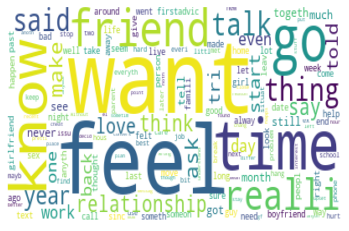

In [50]:
# relationship_advice
# Join all text
rs = " ".join(review for review in train[train["subreddit"]==1]['text'])

# Create and generate a word cloud image:
wordcloud_rs = WordCloud(collocations=False,background_color="white", max_words=150).generate(rs)

# Display the generated image:
plt.imshow(wordcloud_rs, interpolation='bilinear',aspect="auto")
plt.axis("off")

# store to file
plt.savefig("./dataset/relationship_advice_word_cloud.png", format="png")
plt.show()

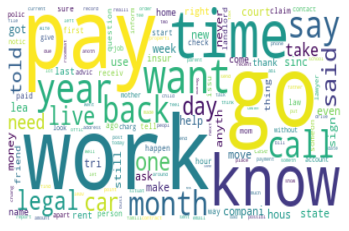

In [51]:
# legaladvice
# Join all text
lg = " ".join(review for review in train[train["subreddit"]==0]['text'])

# Create and generate a word cloud image:
wordcloud_lg = WordCloud(collocations=False,background_color="white", max_words=150).generate(lg)

# Display the generated image:
plt.imshow(wordcloud_lg, interpolation='bilinear',aspect="auto")
plt.axis("off")

# store to file
plt.savefig("./dataset/legaladvice_word_cloud.png", format="png")
plt.show()

### 6. Saving file

In [52]:
X_train.to_csv('./dataset/X_train.csv', index=True)
X_test.to_csv('./dataset/X_test.csv', index=True)
y_train.to_csv('./dataset/y_train.csv', index=True)
y_test.to_csv('./dataset/y_test.csv', index=True)